In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

text_color = '#eaeaea'
background_color = '#151515'
plt.rcParams.update({
    'font.size': 14,
    "axes.grid": True,
    'savefig.facecolor': background_color,
    'axes.facecolor': background_color,
    'figure.facecolor': background_color,
    "ytick.color": text_color,
    "xtick.color": text_color,
    "axes.labelcolor": text_color,
    "axes.edgecolor": text_color,
    "axes.titlecolor": text_color,
    'patch.edgecolor': 'none',
    'legend.labelcolor': text_color,
    'grid.color': text_color,
    'grid.alpha': 0.3,
    'savefig.bbox': 'tight',
    'savefig.dpi': 400,
})

## Loading data

In [2]:
posts = pd.read_csv('data/posts.csv')
posts['date'] = pd.to_datetime(posts['date'])
posts.sample(10, random_state=0xCAFE)

,site,date,word_count,grade_level,comment_count
2433,andrewsullivan,2022-02-19,1840,9.6,0
1240,freddiedeboer,2022-09-13,1025,8.7,324
924,freddiedeboer,2021-10-18,4050,8.1,20
946,freddiedeboer,2021-11-08,553,8.4,372
928,freddiedeboer,2021-10-26,483,8.6,72
1040,freddiedeboer,2022-01-31,283,8.3,0
290,slowboring,2021-11-04,1178,13.0,463
158,slowboring,2021-05-18,2598,10.8,85
2010,noahpinion,2021-11-30,2198,10.5,64
618,freddiedeboer,2017-03-31,351,10.1,0


In [3]:
comments = pd.read_csv('data/comments.csv')
comments.sample(10, random_state=0xCAFE)

,site,word_count,grade_level
2366,slowboring,33,8.5
2795,slowboring,31,3.8
36147,noahpinion,51,5.4
11426,freddiedeboer,59,12.2
14181,freddiedeboer,8,4.1
39619,noahpinion,5,-1.9
15970,freddiedeboer,8,4.1
39654,noahpinion,53,16.0
21765,commonsense,1,-3.5
33933,noahpinion,14,3.7


## Distributions of posts/comment lengths
Look at the distribution of `word_count` for both posts and comments.
We want to see if there are particularly short posts/comments that should be excluded from our analysis.

In [4]:
(posts
 .groupby('site')
 ['word_count']
 .describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])
 .round(1)
 .sort_values('50%')
 )

,count,mean,std,min,10%,25%,50%,75%,90%,max
site,,,,,,,,,,
freddiedeboer,717.0,1531.7,1158.4,1.0,380.6,708.0,1275.0,1988.0,2981.4,8266.0
commonsense,436.0,1697.0,1392.9,1.0,134.0,575.0,1690.0,2412.8,3019.0,12638.0
noahpinion,519.0,2257.3,1087.6,41.0,1346.0,1700.0,2109.0,2550.5,3075.2,11664.0
slowboring,597.0,2331.0,873.9,6.0,1416.6,1900.0,2291.0,2742.0,3339.8,10778.0
andrewsullivan,282.0,4468.2,3247.2,86.0,2398.4,2917.2,3542.0,4313.5,8082.9,17297.0


In [5]:
(comments
 .groupby('site')
 ['word_count']
 .describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])
 .round(1)
 .sort_values('50%')
 )

,count,mean,std,min,10%,25%,50%,75%,90%,max
site,,,,,,,,,,
commonsense,10000.0,63.9,87.1,0.0,7.0,16.0,36.0,78.0,150.0,1530.0
freddiedeboer,10000.0,74.0,97.3,0.0,9.0,19.0,44.0,91.0,171.0,1648.0
slowboring,10000.0,69.9,74.6,0.0,11.0,24.0,48.0,88.0,153.0,1064.0
noahpinion,10000.0,85.0,106.3,0.0,9.0,22.0,50.0,106.0,201.1,1504.0


Here we see that there are a few outliers of particularly short comments and posts.
The Flesh-Kincaid test doesn't work particularly well for these short pieces of text, and we therefore exclude them from our
subsequent analysis.

Note that this entails excluding the majority of comments from all newsletters since their are many short comments.

In [6]:
post_min_length = 500
comment_min_length = 50

## Distribution of Flesh-Kincaid grade-levels

We use the
[Flesh-Kincaid test](https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests#Flesch%E2%80%93Kincaid_grade_level)
to quantify the US grade level of posts and comments from these newsletters.
That metrics has been computed from text and is available in the data.

In the subsequent analysis, comments with a KF test value greater than 20 are excluded as they generally correspond to improperly formatted text.
E.g., a bulleted list where each entry is not terminated with a period and thereby
the entire list is treated as single sentence.

In [7]:
max_fk_value = 20

In [8]:
post_grade_level_dists = (
    posts
    [(posts['word_count'] >= post_min_length) &
     (posts['grade_level'] <= max_fk_value)]
    .groupby('site')
    ['grade_level']
    .describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])
    .round(1)
    .sort_values('50%')
)
post_grade_level_dists

,count,mean,std,min,10%,25%,50%,75%,90%,max
site,,,,,,,,,,
commonsense,328.0,8.7,1.6,5.1,6.8,7.5,8.7,9.8,10.8,13.5
andrewsullivan,275.0,8.8,1.0,4.5,7.6,8.4,9.0,9.4,10.0,11.7
freddiedeboer,613.0,9.9,2.0,3.8,7.6,8.7,9.9,11.2,12.3,17.8
noahpinion,507.0,10.3,1.3,5.4,8.7,9.5,10.3,11.1,12.0,15.0
slowboring,581.0,11.0,1.2,7.6,9.6,10.2,10.8,11.7,12.5,15.3


In [9]:
comment_grade_level_dists = (
    comments
    [(comments['word_count'] >= comment_min_length) &
     (comments['grade_level'] <= max_fk_value)]
    .groupby('site')
    ['grade_level']
    .describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])
    .round(1)
    .sort_values('mean')
)

# use the total comment count from posts metadata rather filtered sample size
comment_grade_level_dists['count'] = (
    posts
    .groupby('site')
    ['comment_count']
    .sum()
)

comment_grade_level_dists

,count,mean,std,min,10%,25%,50%,75%,90%,max
site,,,,,,,,,,
commonsense,155128,8.2,3.0,0.9,4.7,6.1,7.8,9.9,12.0,20.0
freddiedeboer,65091,9.4,3.1,0.9,5.7,7.2,9.1,11.3,13.7,20.0
noahpinion,27999,9.9,3.0,0.2,6.3,7.8,9.6,11.7,14.0,20.0
slowboring,148235,10.1,3.1,0.9,6.3,7.8,9.8,12.0,14.3,20.0


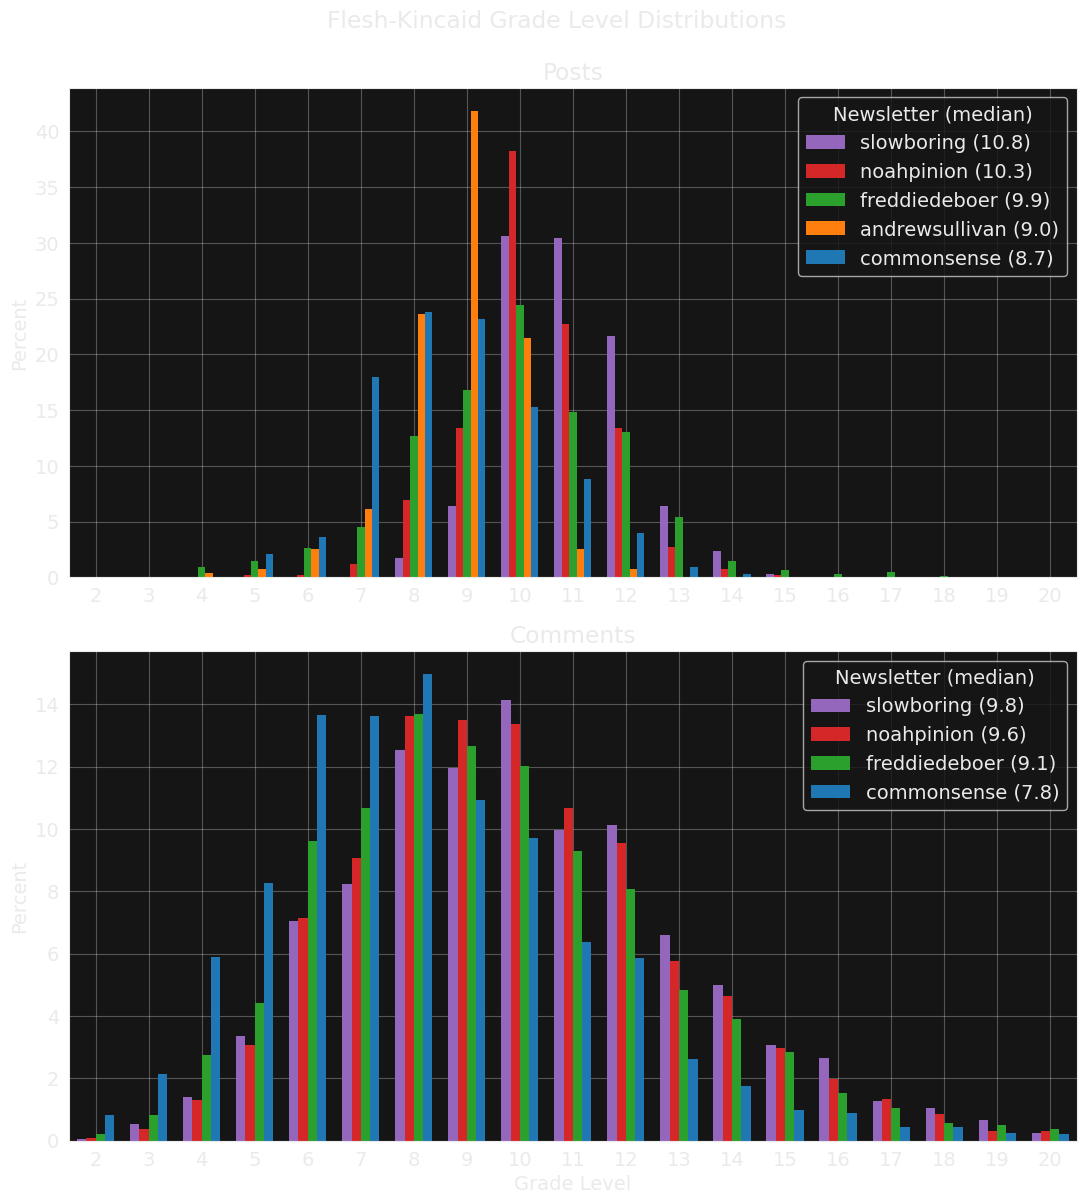

In [10]:
# plot grade level distributions

site_colors = dict(zip(post_grade_level_dists.index,
                       plt.rcParams['axes.prop_cycle'].by_key()['color']))

posts_plot_data: pd.DataFrame = (
    posts
    .assign(grade_level=posts['grade_level'].round().astype(int))
    [(posts['word_count'] >= post_min_length) &
     (posts['grade_level'] <= max_fk_value)]
    .pivot_table('word_count', 'grade_level', 'site', aggfunc='count', fill_value=0)
)

comments_plot_data: pd.DataFrame = (
    comments
    .assign(grade_level=comments['grade_level'].round().astype(int))
    [(comments['word_count'] >= comment_min_length) &
     (comments['grade_level'] <= max_fk_value)]
    .pivot_table('word_count', 'grade_level', 'site', aggfunc='count', fill_value=0)
)

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(13, 13))
axs: list[plt.Axes] = axs

for ax, data, stats in zip(axs, [posts_plot_data, comments_plot_data],
                           [post_grade_level_dists, comment_grade_level_dists]):
    for x in range(0, max_fk_value + 1):
        if x in data.index:
            continue
        for col in data.columns:
            data.loc[x, col] = 0
    data = data.sort_index()
    data = data.div(data.sum(axis=0)).mul(100)
    data = data[[c for c in post_grade_level_dists.index[::-1] if c in data.columns]]

    data.plot.bar(ax=ax, color=[site_colors[c] for c in data.columns], width=0.7)
    plt.sca(ax)
    plt.xticks(rotation=0)
    plt.xlim(1.5, 20.5)
    plt.ylabel('Percent')

    legend = ax.get_legend()
    handles = legend.legendHandles
    legend.remove()
    labels = [f'{c} ({stats.loc[c]["50%"]:.1f})' for c in data.columns]
    legend = ax.legend(handles, labels, title='Newsletter (median)')
    plt.setp(legend.get_title(), color=text_color)

axs[0].set_xlabel('')
axs[1].set_xlabel('Grade Level')
for ax, name in zip(axs, ['Posts', 'Comments']):
    ax.set_title(name)

plt.suptitle('Flesh-Kincaid Grade Level Distributions', color=text_color)
plt.subplots_adjust(hspace=0.15, top=0.92)
fig.savefig('docs/fig/grade_level_dists.png')


In [11]:
# generate Markdown tables for inclusion in report

def create_column_mappings(count_name):
    return {
        'site': 'Newsletter',
        'count': count_name,
        'mean': 'Mean',
        'std': 'Std',
        'min': 'Min',
        'max': 'Max'
    }


(post_grade_level_dists
 .iloc[::-1]
 .assign(count=lambda x: x['count'].astype(int))
 .reset_index()
 .rename(columns=create_column_mappings('Posts'))
 .pipe(lambda x: print(x.to_markdown(index=False)))
 )

print()

(comment_grade_level_dists
 .iloc[::-1]
 .assign(count=pd.Series(comment_grade_level_dists['count']).map(lambda x: f'{x:,}'))
 .reset_index()
 .rename(columns=create_column_mappings('Comments'))
 .pipe(lambda x: print(x.to_markdown(index=False)))
 )

| Newsletter     |   Posts |   Mean |   Std |   Min |   10% |   25% |   50% |   75% |   90% |   Max |
|:---------------|--------:|-------:|------:|------:|------:|------:|------:|------:|------:|------:|
| slowboring     |     581 |   11   |   1.2 |   7.6 |   9.6 |  10.2 |  10.8 |  11.7 |  12.5 |  15.3 |
| noahpinion     |     507 |   10.3 |   1.3 |   5.4 |   8.7 |   9.5 |  10.3 |  11.1 |  12   |  15   |
| freddiedeboer  |     613 |    9.9 |   2   |   3.8 |   7.6 |   8.7 |   9.9 |  11.2 |  12.3 |  17.8 |
| andrewsullivan |     275 |    8.8 |   1   |   4.5 |   7.6 |   8.4 |   9   |   9.4 |  10   |  11.7 |
| commonsense    |     328 |    8.7 |   1.6 |   5.1 |   6.8 |   7.5 |   8.7 |   9.8 |  10.8 |  13.5 |

| Newsletter    | Comments   |   Mean |   Std |   Min |   10% |   25% |   50% |   75% |   90% |   Max |
|:--------------|:-----------|-------:|------:|------:|------:|------:|------:|------:|------:|------:|
| slowboring    | 148,235    |   10.1 |   3.1 |   0.9 |   6.3 |   7.8 |   9.8

## Comments per a post

In [12]:
post_comment_dists = (
    posts
    .groupby('site')
    ['comment_count']
    .describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])
    .drop(['andrewsullivan'], axis=0)
    .round(1)
    .sort_values('50%', ascending=False)
)
post_comment_dists

,count,mean,std,min,10%,25%,50%,75%,90%,max
site,,,,,,,,,,
commonsense,436.0,355.8,312.1,0.0,0.0,56.5,321.5,584.8,798.0,1641.0
slowboring,597.0,248.3,123.5,0.0,107.0,160.0,232.0,317.0,414.2,1034.0
noahpinion,519.0,53.9,42.4,0.0,15.8,25.5,41.0,71.5,106.0,268.0
freddiedeboer,717.0,90.8,123.4,0.0,0.0,0.0,37.0,129.0,273.8,663.0


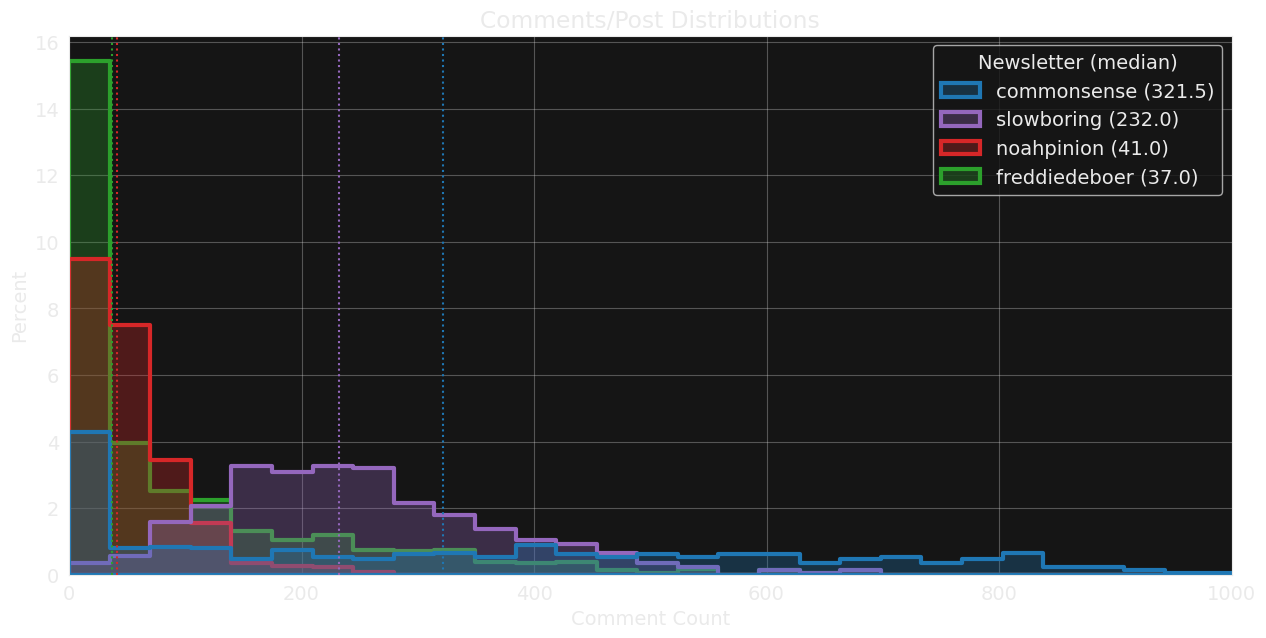

In [13]:
fig, ax = plt.subplots(figsize=(15, 7))
comment_count_hist_data = (
    posts
    [posts['site'].isin(post_comment_dists.index)]
)
sns.histplot(comment_count_hist_data,
             x="comment_count", hue="site", stat='percent', hue_order=post_comment_dists.index,
             palette=[site_colors[s] for s in post_comment_dists.index],
             # multiple='dodge',
             element='step', alpha=0.3, linewidth=3,
             ax=ax)
plt.xlim(0, 1000)
plt.xlabel('Comment Count')

legend = ax.get_legend()
handles = legend.legendHandles
legend.remove()
labels = [f'{site} ({median})' for site, median in post_comment_dists['50%'].items()]
legend = ax.legend(handles, labels, title='Newsletter (median)')
plt.setp(legend.get_title(), color=text_color)

for handle, median in zip(handles, post_comment_dists['50%']):
    plt.axvline(median, color=handle.get_edgecolor(), linestyle=':')

plt.title('Comments/Post Distributions')
fig.savefig('docs/fig/post_comments_dists.png')

In [14]:
(post_comment_dists
 .reset_index()
 .rename(columns=create_column_mappings('Posts'))
 .pipe(lambda x: print(x.to_markdown(index=False)))
 )

| Newsletter    |   Posts |   Mean |   Std |   Min |   10% |   25% |   50% |   75% |   90% |   Max |
|:--------------|--------:|-------:|------:|------:|------:|------:|------:|------:|------:|------:|
| commonsense   |     436 |  355.8 | 312.1 |     0 |   0   |  56.5 | 321.5 | 584.8 | 798   |  1641 |
| slowboring    |     597 |  248.3 | 123.5 |     0 | 107   | 160   | 232   | 317   | 414.2 |  1034 |
| noahpinion    |     519 |   53.9 |  42.4 |     0 |  15.8 |  25.5 |  41   |  71.5 | 106   |   268 |
| freddiedeboer |     717 |   90.8 | 123.4 |     0 |   0   |   0   |  37   | 129   | 273.8 |   663 |


# Comment volume over time

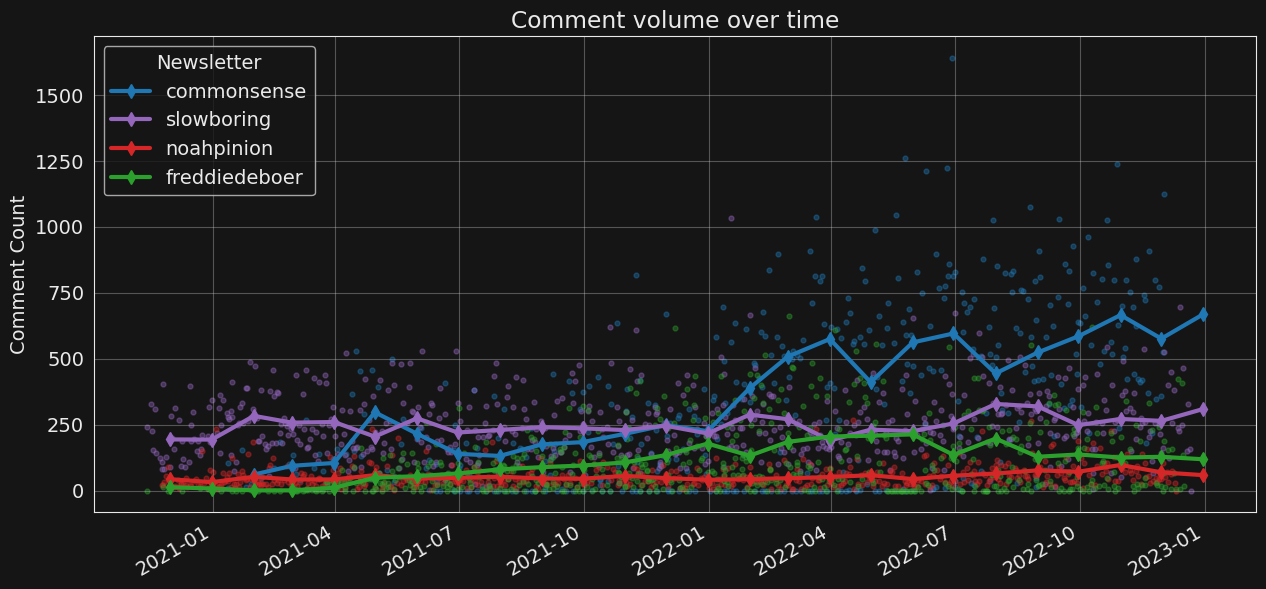

In [68]:
fig, ax = plt.subplots(figsize=(15, 7))
for site in post_comment_dists.index:
    site_posts = posts[(posts['site'] == site) & (posts['date'] >= pd.Timestamp('2020-11-01'))]
    site_posts = site_posts.sort_values('date')
    site_posts.plot('date', 'comment_count', color=site_colors[site], style='o', alpha=0.4, ms=4, ax=ax, label='',
                    zorder=0)

    avg_comments = (
        site_posts
        .assign(month=site_posts['date'] + pd.offsets.MonthEnd())
        .pipe(lambda x: x[x['comment_count'] > 0])
        .groupby('month')
        ['comment_count']
        .mean()
    )
    avg_comments.plot(color=site_colors[site], style='-d', lw=3, ms=7, ax=ax, label=site, zorder=1)

legend = plt.legend(loc='upper left', title='Newsletter')
plt.setp(legend.get_title(), color=text_color)
plt.xlabel('')
plt.ylabel('Comment Count')
plt.title('Comment volume over time')
fig.savefig('docs/fig/comment_volume_time.png')